## Set-up

In [31]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import random
from NMF_iter import normalize_curves

sns.set_theme()
colors = sns.color_palette("deep")

In [2]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()

    return fig, ax

In [3]:
def initialize_W(df, X, region_cons_df):
    W = df[['region']]
    W = W.merge(region_cons_df, how='left', left_on='region', right_index=True)
    W.drop('region', axis=1, inplace=True)
    W = W.mul(X.sum(axis=1), axis=0)
    return W

In [4]:
def initialize_W_random(X, n_components):
    W = pd.DataFrame(np.random.rand(len(X), n_components), index=X.index, columns=[f"Component {k+1}" for k in range(n_components)])
    W = W.div(W.sum(axis=1), axis=0)
    return W

In [5]:
def initialize_W_equal(n_components):
    W_init = pd.DataFrame(index=df.index)
    for k in range(n_components):
        W_init[f'Component {k+1}'] = 1 / n_components
    W_init

In [6]:
month_mapping = {
    '01': 'January',
    '02': 'February',
    '03': 'March',
    '04': 'April',
    '05': 'May',
    '06': 'June',
    '07': 'July',
    '08': 'August',
    '09': 'September',
    '10': 'October',
    '11': 'November',
    '12': 'December'
}

n_components = 3 # Number of components for the matrix factorization

colormap = ListedColormap([colors[k] for k in range(n_components)])

# Process data

## Data matrix $X$

In [19]:
input_df = pd.read_csv('data/daily_curves_fixed.csv', index_col=0)
print(len(input_df))
input_df.head(3)

11646


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,648.877,658.723,745.817,773.431,828.180,831.509,758.732,669.630,596.548,518.853
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,678.540,666.579,730.333,764.207,819.056,825.176,754.773,706.062,629.708,540.431
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,845.339,798.132,870.231,891.262,980.735,926.445,845.014,756.975,688.183,601.762


In [20]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
# df = df[df.month.isin(months)]
# df = df[(df.month == '10')&(df.daytype=='Working day')]
print(len(df))
df.head(3)

11646


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,region,year,month,daytype
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,828.180,831.509,758.732,669.630,596.548,518.853,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,819.056,825.176,754.773,706.062,629.708,540.431,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,980.735,926.445,845.014,756.975,688.183,601.762,Calabria,2021,01,Working day


In [21]:
X = df.drop(unit_info.columns, axis=1)
X = X.div(X.sum(axis=1), axis=0)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Calabria_2021-01-02_Saturday,0.035550,0.033102,0.029717,0.028863,0.029419,0.029717,0.031670,0.033844,0.037269,0.041676,...,0.041718,0.042351,0.047951,0.049726,0.053246,0.053460,0.048781,0.043052,0.038354,0.033358
Calabria_2021-01-03_Holiday,0.033443,0.029513,0.027858,0.027011,0.025395,0.028277,0.029806,0.031487,0.034317,0.041372,...,0.043736,0.042965,0.047074,0.049257,0.052793,0.053187,0.048649,0.045510,0.040588,0.034834
Calabria_2021-01-04_Working day,0.029862,0.024866,0.023982,0.023923,0.024048,0.025256,0.028566,0.034543,0.038185,0.048945,...,0.046710,0.044101,0.048085,0.049247,0.054191,0.051191,0.046692,0.041827,0.038026,0.033251
Calabria_2021-01-05_Working day,0.033850,0.030881,0.029073,0.028775,0.027999,0.029155,0.032742,0.037978,0.041914,0.052139,...,0.044708,0.042871,0.046004,0.049792,0.050000,0.048766,0.044880,0.038781,0.034489,0.029378
Calabria_2021-01-06_Holiday,0.032438,0.028625,0.027462,0.027464,0.026969,0.027740,0.028923,0.031700,0.034598,0.044711,...,0.045380,0.042887,0.045624,0.049557,0.050506,0.049244,0.046810,0.042910,0.038848,0.034480


In [32]:
p = len(X.columns)

## Initialization matrices $W_{init}$, $H_{init}$

### Initialize $W$ with year-level sector consumption distribution

In [22]:
cons_df = pd.read_excel('data/consumption/consumption_chart.xlsx')
cons_df.head(3)

,Regione,Settore corretto,Sum of Consumo corretto,year,Zone
0,Veneto,Agricoltura,708.884874,2018,North
1,Veneto,Domestico,5595.518524,2018,North
2,Veneto,Industria,14741.332908,2018,North


In [24]:
# Each year features more or less the same sector distribution, so we take arbtrarily the last year
region_cons_df = pd.pivot_table(cons_df[cons_df.year == 2022], values='Sum of Consumo corretto', index='Zone', columns='Settore corretto', aggfunc='sum')
# We remove agriculture since it is too small
region_cons_df.drop('Agricoltura', axis=1, inplace=True)
region_cons_df = region_cons_df.div(region_cons_df.sum(axis=1), axis=0)
region_cons_df.index = region_cons_df.index.str.replace('-', '.')
region_cons_df

Settore corretto,Domestico,Industria,Servizi
Zone,,,
Calabria,0.418757,0.169124,0.412119
Centre.North,0.227537,0.456270,0.316193
Centre.South,0.296825,0.311082,0.392093
North,0.183974,0.520047,0.295979
Sardinia,0.287522,0.439368,0.273110
Sicily,0.342059,0.353885,0.304057
South,0.255487,0.467103,0.277410


In [25]:
# Now se should find 4 components (according to the FPCA analysis ran before), so we need to add one more.
# Given that Sardinia and South/Sicily have a similar sector mix with different daily curves and that they seem to differ mainly in type of industry, we choose to split the Industry consumption
# From the industry subsector distribution it seems that the "metalli non ferrosi" is responsible of the deviance of Sardinia from South and Sicily

imcei_df = pd.read_excel('/Users/guillaume/Documents/GitHub/BSS/data/consumption/export_imcei_region_chart.xlsx')
imcei_df.head(3)

,Anno,Mese,Zone,Regione,Settore,Tipo Tensione,Imcei Mensile,Consumi (Gwh)
0,2021,Febbraio,North,Lombardia,SIDERURGIA,AT,56.278856,609.47
1,2021,Febbraio,North,Friuli-Venezia Giulia,SIDERURGIA,AT,16.857709,182.56
2,2021,Febbraio,North,Veneto,SIDERURGIA,AT,16.632398,180.12


In [26]:
# Each year features more or less the same sector distribution, so we take arbtrarily the last year
region_imcei_df = pd.pivot_table(imcei_df, values='Consumi (Gwh)', index='Zone', columns='Settore', aggfunc='sum')
region_imcei_df = region_imcei_df.fillna(0).div(region_imcei_df.fillna(0).sum(axis=1), axis=0)
region_imcei_df

Settore,ALIMENTARE,ALTRI,CARTARIA,CEMENTO CALCE E GESSO,CERAMICHE E VETRARIE,CHIMICA,MECCANICA,METALLI NON FERROSI,MEZZI DI TRASPORTO,SIDERURGIA
Zone,,,,,,,,,,
Calabria,0.000000,0.732288,0.000000,0.181330,0.000000,0.086383,0.000000,0.000000,0.000000,0.000000
Centre-North,0.018280,0.149364,0.256549,0.036830,0.048687,0.101659,0.099522,0.115424,0.031796,0.141888
Centre-South,0.033223,0.225481,0.047489,0.090762,0.013459,0.092326,0.035709,0.071985,0.106571,0.282995
North,0.013951,0.138182,0.009241,0.025275,0.023056,0.092524,0.082830,0.086433,0.018670,0.509838
Sardinia,0.030628,0.060916,0.008278,0.042906,0.000000,0.253736,0.037780,0.565756,0.000000,0.000000
Sicily,0.026833,0.274475,0.000000,0.144020,0.000000,0.181337,0.178375,0.018193,0.007023,0.169744
South,0.103417,0.237429,0.010274,0.209634,0.021636,0.070357,0.011814,0.003816,0.103443,0.228179


In [27]:
# region_cons_df['Industria 2'] = region_imcei_df['METALLI NON FERROSI'] * region_cons_df['Industria']
# region_cons_df['Industria 1'] = region_cons_df['Industria'] - region_cons_df['Industria 2']
# region_cons_df = region_cons_df[['Domestico', 'Servizi', 'Industria 1', 'Industria 2']]
region_cons_df

Settore corretto,Domestico,Industria,Servizi
Zone,,,
Calabria,0.418757,0.169124,0.412119
Centre.North,0.227537,0.456270,0.316193
Centre.South,0.296825,0.311082,0.392093
North,0.183974,0.520047,0.295979
Sardinia,0.287522,0.439368,0.273110
Sicily,0.342059,0.353885,0.304057
South,0.255487,0.467103,0.277410


In [28]:
skip = True
if not skip:  
    # Let's split the servizi in 2 (maybe for business active during the days and those also active during the evening (like restoration))
    region_cons_df['Servizi 2'] = region_cons_df['Servizi'] / 2
    region_cons_df['Servizi 1'] = region_cons_df['Servizi'] - region_cons_df['Servizi 2']
    region_cons_df = region_cons_df[['Domestico', 'Industria', 'Servizi 1', 'Servizi 2']]
    region_cons_df.index = region_cons_df.index.str.replace('-', '.')
else:
    print("skipped")

skipped


In [29]:
W_init = initialize_W(df, X, region_cons_df)
W_init

,Domestico,Industria,Servizi
Calabria_2021-01-02_Saturday,0.418757,0.169124,0.412119
Calabria_2021-01-03_Holiday,0.418757,0.169124,0.412119
Calabria_2021-01-04_Working day,0.418757,0.169124,0.412119
Calabria_2021-01-05_Working day,0.418757,0.169124,0.412119
Calabria_2021-01-06_Holiday,0.418757,0.169124,0.412119
...,...,...,...
South_2022-12-26_Holiday,0.255487,0.467103,0.277410
South_2022-12-27_Working day,0.255487,0.467103,0.277410
South_2022-12-28_Working day,0.255487,0.467103,0.277410
South_2022-12-29_Working day,0.255487,0.467103,0.277410


### Initialize $W$ with equal values

In [17]:
# /!\ CAUTION /!\: This may cause the algorithm to converge to a local minimum where all the profiles are the same
skip = False
if not skip:
    W_init = pd.DataFrame(index=df.index)
    for k in range(n_components):
        W_init[f'Component {k+1}'] = 1 / n_components
    W_init
else:
    print("skipped")

### Initialize $W$ with random values

In [11]:
W_init = initialize_W_random(X, n_components)
W_init

,Component 1,Component 2,Component 3,Component 4
Calabria_2021-01-02_Saturday,0.039775,0.102293,0.123268,0.734664
Calabria_2021-01-03_Holiday,0.237100,0.338333,0.166392,0.258174
Calabria_2021-01-04_Working day,0.493584,0.076757,0.423870,0.005789
Calabria_2021-01-05_Working day,0.311334,0.244944,0.196441,0.247282
Calabria_2021-01-06_Holiday,0.246102,0.202059,0.269990,0.281849
...,...,...,...,...
South_2022-12-27_Working day,0.307193,0.345338,0.167493,0.179975
South_2022-12-28_Working day,0.101788,0.021430,0.563226,0.313556
South_2022-12-29_Working day,0.320311,0.142931,0.532070,0.004688
South_2022-12-30_Working day,0.420486,0.369874,0.034908,0.174732


### Initialize $H$ with equal values

In [12]:
# Our initial guess for the matrix of components is a constant curve. The condition on the norm of the components being 1 yields S_k = (1/24, ..., 1/24)
H_init = np.ones((n_components, 24)) / 24

### Initialize $H$ with custom values

In [19]:
# Initialize with results from the batch run
H_init = np.load(f'data/nmf_results/{n_components}comp_cluster_centers_1000runs.npy')

# NMF

270 iterations
3.185725517315204e-06 error


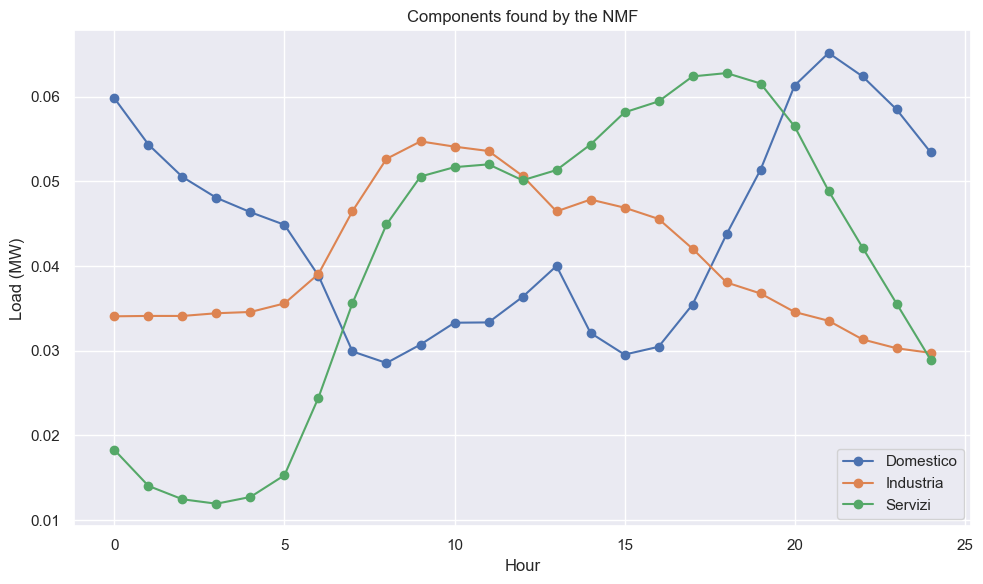

In [41]:
random_state = None
tol = 1e-4
init = 'custom'
max_iter = 10000
solver = 'mu'
verbose = 0
beta_loss = 'frobenius'

fig, axs = plt.subplots(1, 1, figsize=(10, 6))

model = NMF(
    n_components=n_components,
    random_state=random_state,
    beta_loss=beta_loss,
    solver=solver,
    tol=tol,
    init=init,
    max_iter=max_iter,
    verbose=verbose
)

W_init = initialize_W(df, X, region_cons_df)
# H_init = np.load(f'data/nmf_results/{n_components}comp_cluster_centers_1000runs.npy')
H_init = normalize_curves(np.ones((n_components, p)))

W = model.fit_transform(
    X.values,
    W=W_init.values.copy(order='C'),
    H=H_init
)

H = model.components_

print('{} iterations'.format(model.n_iter_))
print('{} error'.format(model.reconstruction_err_/X.size))
plot_components(H, ax=axs, title=f"Components found by the NMF", component_names=W_init.columns)
plt.tight_layout()
# plt.savefig('documents/plots/profiles/monthly/month{}_3_sectors_profiles.png'.format('-'.join(months)))

In [35]:
# HOTFIX: reordering components for plotting
reordering = np.array([2, 1, 0])
W = W[:, reordering]
H = H[reordering, :]

outfile = f'data/nmf_results/WH_{n_components}comp_cons_init_1run.npz'
np.savez(outfile, W=W, H=H)
print("Saved results at", outfile)

Saved results at data/nmf_results/WH_3comp_cons_init_1run.npz


In [32]:
H

array([[0.05743494, 0.05640811, 0.05474253, 0.05365151, 0.05222392,
        0.05077971, 0.04522567, 0.04100393, 0.04161937, 0.04320135,
        0.04481359, 0.04510205, 0.04587597, 0.04380061, 0.03926734,
        0.03500058, 0.03328477, 0.03077328, 0.03032253, 0.03285486,
        0.03919048, 0.04510345, 0.04501303, 0.04510187],
       [0.01408518, 0.01371358, 0.014236  , 0.01510463, 0.01636326,
        0.01930667, 0.02992959, 0.04627524, 0.05771214, 0.06241263,
        0.06199852, 0.06214975, 0.05772346, 0.05382371, 0.06018863,
        0.0627801 , 0.061968  , 0.05847695, 0.05145483, 0.04596386,
        0.0372029 , 0.03066299, 0.02604682, 0.02284987],
       [0.03694512, 0.02968981, 0.0260624 , 0.02406021, 0.02372401,
        0.02458559, 0.02723441, 0.02683436, 0.0297094 , 0.03309738,
        0.03440463, 0.03368823, 0.03465497, 0.0399683 , 0.03589957,
        0.03789134, 0.04088058, 0.04984018, 0.06010516, 0.06687581,
        0.07037359, 0.06579795, 0.05915258, 0.05140735]])

In [34]:
np.load(f'data/nmf_results/{n_components}comp_cluster_centers_1000runs.npy')

array([[0.04785867, 0.04536911, 0.04348406, 0.04240852, 0.04157425,
        0.04121574, 0.0395969 , 0.03880821, 0.0413414 , 0.04370065,
        0.04492102, 0.04488583, 0.04502495, 0.04447138, 0.04128876,
        0.03929544, 0.03881499, 0.03892681, 0.04035417, 0.04308554,
        0.04705601, 0.04896698, 0.04670426, 0.04448401],
       [0.02376892, 0.02186572, 0.02125418, 0.02128395, 0.02188874,
        0.02386918, 0.03087295, 0.04119065, 0.04949814, 0.05354677,
        0.05375145, 0.05375176, 0.05111542, 0.04942261, 0.05228638,
        0.05396105, 0.05387261, 0.05317751, 0.05062246, 0.04867934,
        0.04430754, 0.03964941, 0.03513887, 0.03135597],
       [0.0383729 , 0.03358614, 0.03100036, 0.02960753, 0.02921918,
        0.0298221 , 0.03163168, 0.03264995, 0.03612858, 0.03932244,
        0.0405421 , 0.04024216, 0.04044546, 0.04273356, 0.04008453,
        0.04072158, 0.04204506, 0.04654261, 0.0517398 , 0.05563571,
        0.05793676, 0.05555423, 0.05080023, 0.04558364]])

## Analysis of concentrations

In [26]:
W = pd.DataFrame(W, index=df.index, columns=W_init.columns)
W[unit_info.columns] = df[unit_info.columns]
W

,Component 1,Component 2,Component 3,Component 4,region,year,month,daytype
Calabria_2021-01-02_Saturday,0.185614,0.165437,0.341690,0.316341,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,0.245398,0.078670,0.326232,0.361683,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,0.324640,0.120923,0.372878,0.198217,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,0.268742,0.264332,0.315754,0.157804,Calabria,2021,01,Working day
Calabria_2021-01-06_Holiday,0.306252,0.111390,0.272972,0.318398,Calabria,2021,01,Holiday
...,...,...,...,...,...,...,...,...
South_2022-12-27_Working day,0.291875,0.104567,0.428658,0.193480,South,2022,12,Working day
South_2022-12-28_Working day,0.392507,0.000023,0.415474,0.227468,South,2022,12,Working day
South_2022-12-29_Working day,0.269446,0.229881,0.279593,0.226250,South,2022,12,Working day
South_2022-12-30_Working day,0.222201,0.078285,0.497172,0.226524,South,2022,12,Working day


In [45]:
X

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Calabria_2021-01-02_Saturday,0.036777,0.034244,0.030743,0.029859,0.030434,0.030742,0.032763,0.035012,0.038555,0.043115,...,0.043962,0.043158,0.043813,0.049605,0.051442,0.055083,0.055305,0.050464,0.044538,0.039677
Calabria_2021-01-03_Holiday,0.034650,0.030578,0.028863,0.027986,0.026312,0.029298,0.030882,0.032623,0.035556,0.042865,...,0.049334,0.045314,0.044515,0.048773,0.051035,0.054698,0.055107,0.050405,0.047152,0.042053
Calabria_2021-01-04_Working day,0.030889,0.025722,0.024807,0.024746,0.024875,0.026124,0.029549,0.035732,0.039499,0.050629,...,0.044629,0.048316,0.045618,0.049739,0.050941,0.056055,0.052952,0.048298,0.043266,0.039334
Calabria_2021-01-05_Working day,0.034875,0.031816,0.029953,0.029646,0.028846,0.030038,0.033733,0.039128,0.043183,0.053717,...,0.044944,0.046061,0.044169,0.047396,0.051299,0.051514,0.050242,0.046238,0.039955,0.035533
Calabria_2021-01-06_Holiday,0.033596,0.029647,0.028442,0.028445,0.027932,0.028731,0.029956,0.032832,0.035834,0.046307,...,0.050172,0.047001,0.044419,0.047253,0.051327,0.052310,0.051003,0.048481,0.044442,0.040235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
South_2022-12-27_Working day,0.027014,0.024709,0.023101,0.023146,0.026042,0.026870,0.032974,0.037586,0.043660,0.049948,...,0.048552,0.045012,0.045061,0.052638,0.053876,0.054638,0.053831,0.051315,0.045522,0.039828
South_2022-12-28_Working day,0.026371,0.022830,0.018943,0.017828,0.017456,0.019112,0.023570,0.030390,0.038630,0.045584,...,0.054782,0.056126,0.054498,0.055217,0.056574,0.057145,0.056351,0.053212,0.047568,0.038459
South_2022-12-29_Working day,0.037030,0.028254,0.031570,0.029849,0.029333,0.030953,0.035457,0.037852,0.041299,0.047584,...,0.047508,0.043959,0.041978,0.048476,0.049206,0.051492,0.049945,0.047552,0.041563,0.035214
South_2022-12-30_Working day,0.032992,0.026450,0.024066,0.022343,0.022660,0.024364,0.028440,0.035859,0.040697,0.051642,...,0.043638,0.044521,0.045235,0.053146,0.054879,0.056614,0.057490,0.053786,0.047607,0.045790


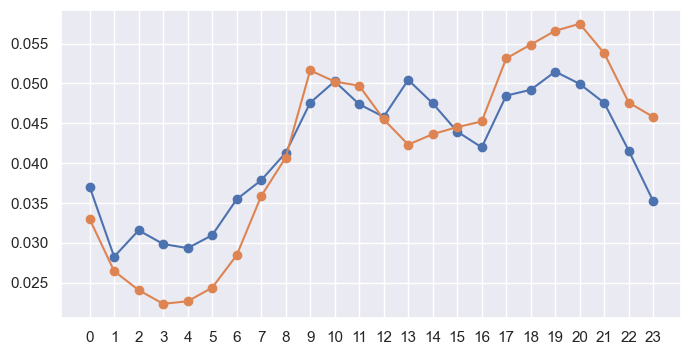

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
obs1 = 'South_2022-12-29_Working day'
obs2 = 'South_2022-12-30_Working day'
ax.plot(X.loc[obs1], marker='o', linestyle='-', label=obs1)
ax.plot(X.loc[obs2], marker='o', linestyle='-', label=obs2)

In [33]:
region_cons_df

Settore corretto,Domestico,Industria,Servizi
Zone,,,
Calabria,0.418757,0.169124,0.412119
Centre.North,0.227537,0.456270,0.316193
Centre.South,0.296825,0.311082,0.392093
North,0.183974,0.520047,0.295979
Sardinia,0.287522,0.439368,0.273110
Sicily,0.342059,0.353885,0.304057
South,0.255487,0.467103,0.277410


Text(0, 0.5, '')

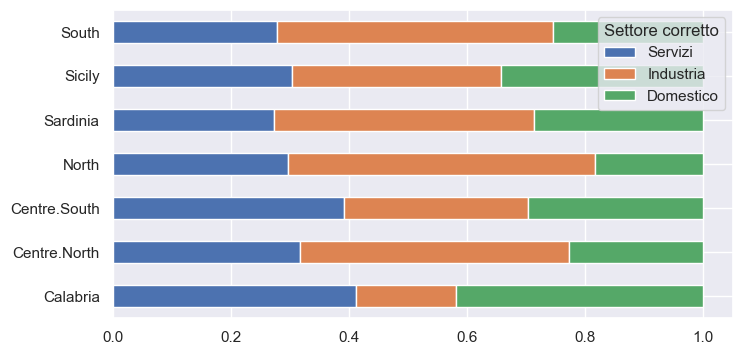

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
region_cons_df[['Servizi', 'Industria', 'Domestico']].plot.barh(stacked=True, ax=ax)
ax.set_ylabel("")

In [35]:
W_region = W.groupby('region')[W_init.columns].sum()
W_region = W_region.div(W_region.sum(axis=1), axis=0)
W_region

,Component 1,Component 2,Component 3,Component 4
region,,,,
Calabria,0.229963,0.218647,0.286393,0.264997
Centre.North,0.315943,0.233370,0.227738,0.222950
Centre.South,0.266334,0.192863,0.266989,0.273814
North,0.307940,0.265482,0.228719,0.197859
Sardinia,0.219975,0.311143,0.220964,0.247917
Sicily,0.199145,0.242212,0.269518,0.289126
South,0.219715,0.254276,0.259807,0.266202


In [ ]:
W_region = W.groupby('region')[['Domestico', 'Industria', 'Servizi']].sum()
W_region = W_region.div(W_region.sum(axis=1), axis=0)
W_region

,Domestico,Industria,Servizi
region,,,
Calabria,0.310943,0.324652,0.364405
Centre.North,0.207935,0.452778,0.339287
Centre.South,0.279447,0.339054,0.381499
North,0.203414,0.482923,0.313663
Sardinia,0.311256,0.449295,0.239449
Sicily,0.351322,0.327933,0.320745
South,0.320259,0.367659,0.312082


Text(0, 0.5, '')

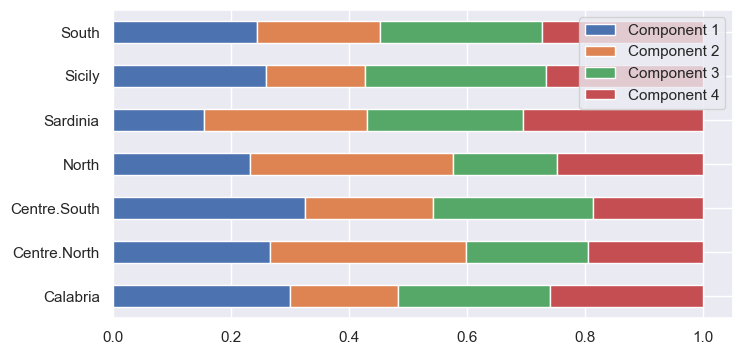

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
W_region.plot.barh(stacked=True, ax=ax)
ax.set_ylabel("")

Text(0, 0.5, '')

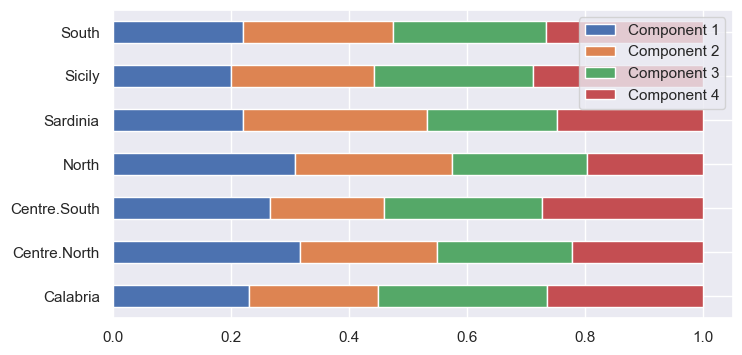

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
W_region.plot.barh(stacked=True, ax=ax)
ax.set_ylabel("")

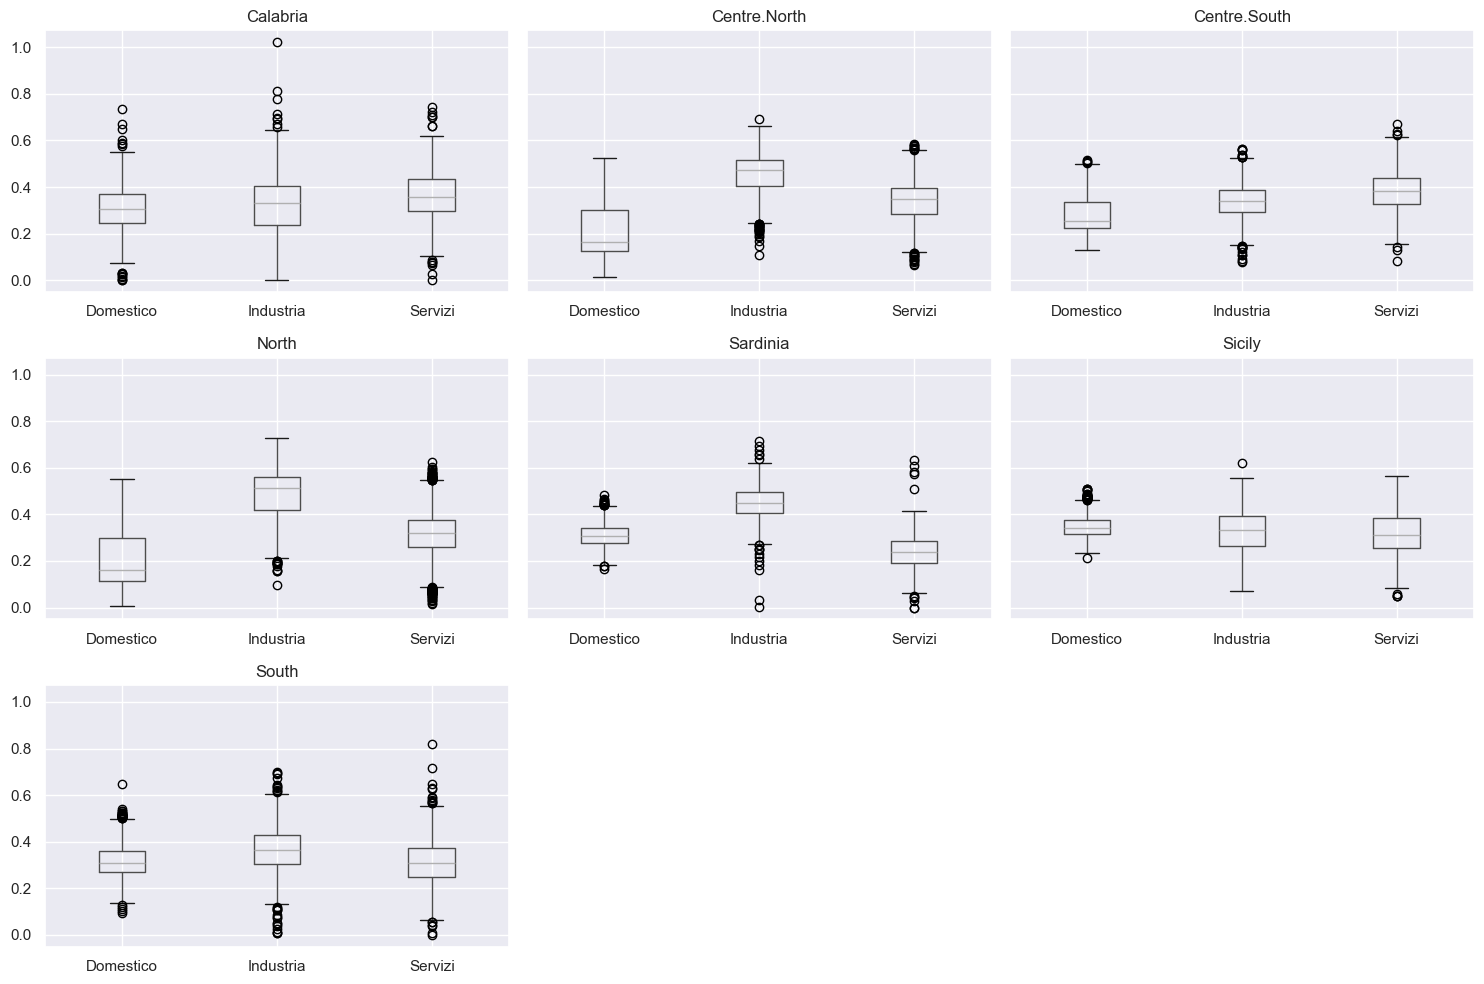

In [31]:
W.groupby('region')[['Domestico', 'Industria', 'Servizi']].boxplot(figsize=(15,10))
plt.tight_layout()

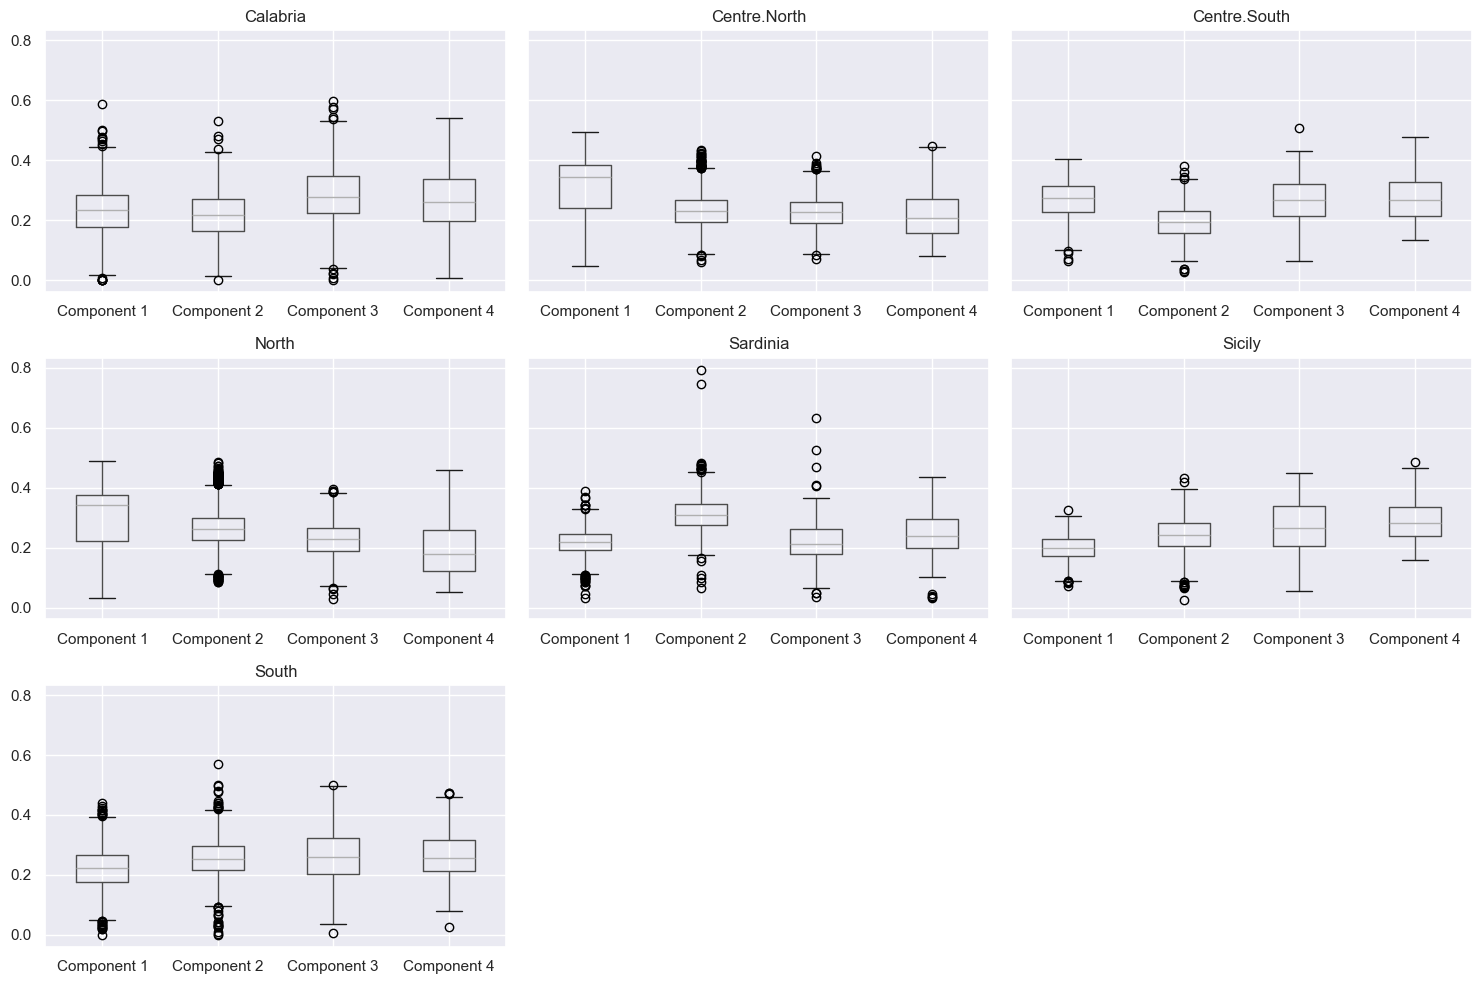

In [37]:
W.groupby('region')[W_init.columns].boxplot(figsize=(15,10))
plt.tight_layout()

<Axes: xlabel='component', ylabel='concentration'>

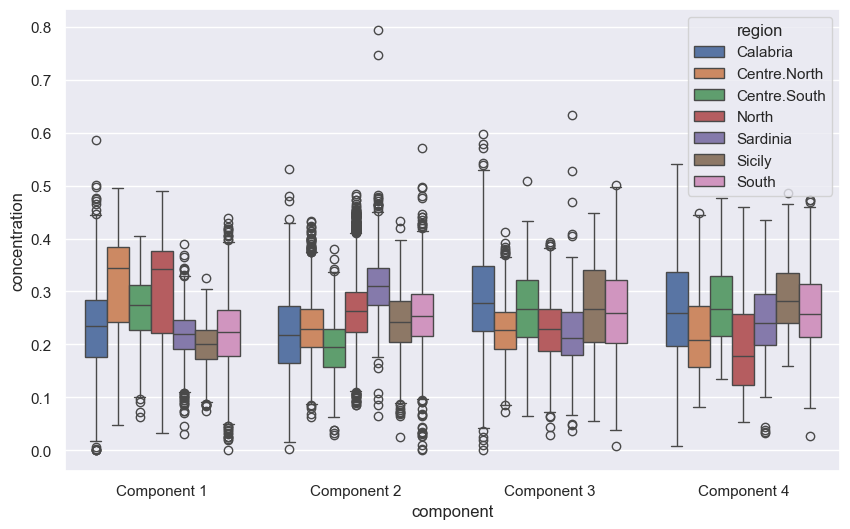

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='component',
    y='concentration',
    hue='region',
)

<Axes: xlabel='month', ylabel='concentration'>

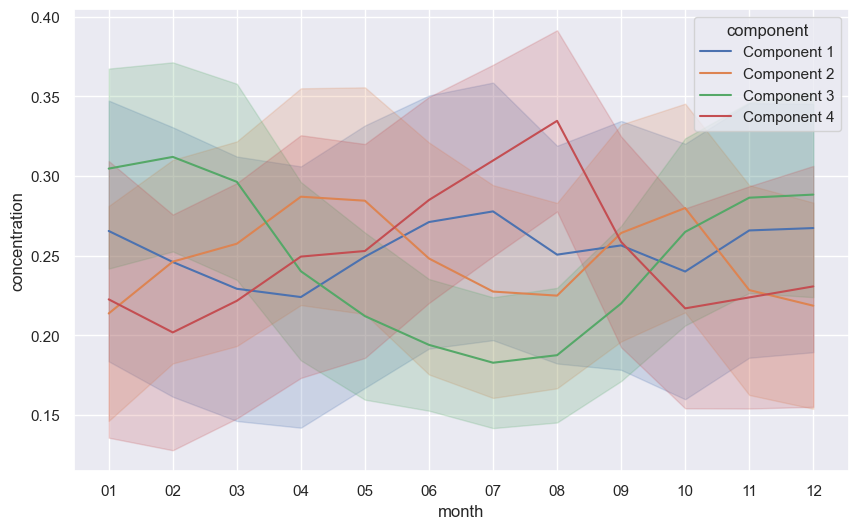

In [39]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
    errorbar='sd'
)

<Axes: xlabel='month', ylabel='concentration'>

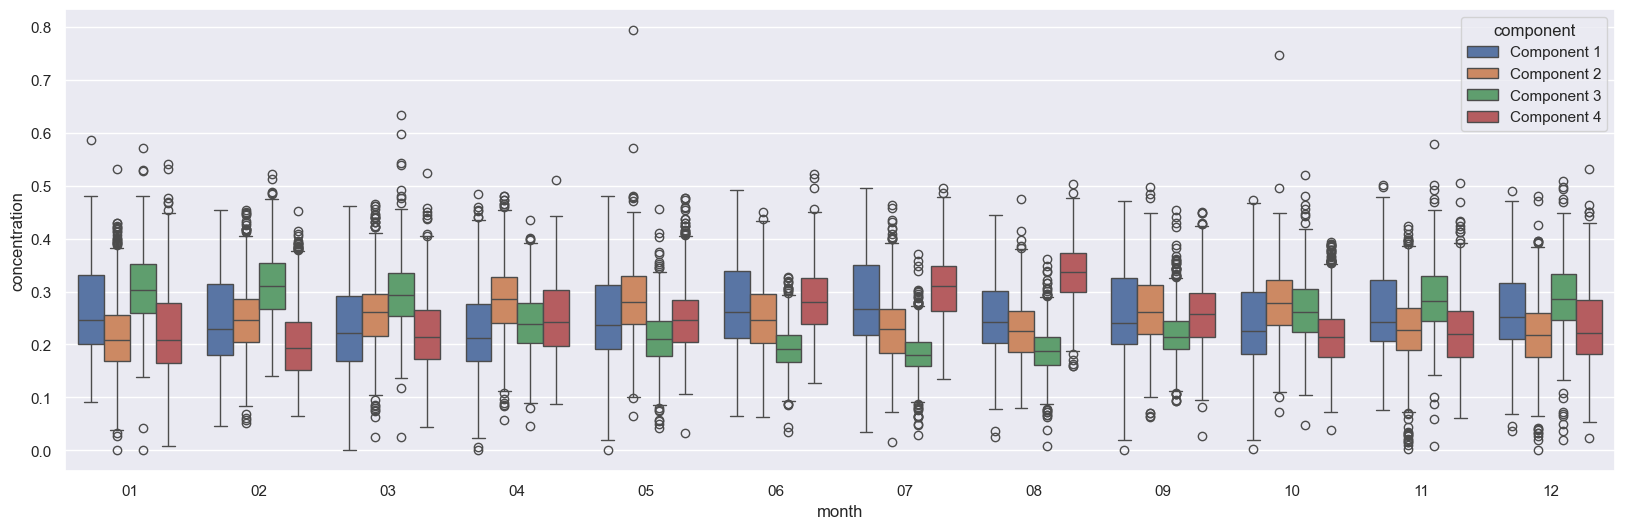

In [40]:
plt.figure(figsize=(20,6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
)

In [41]:
W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration')

,region,year,month,daytype,component,concentration
0,Calabria,2021,01,Saturday,Component 1,0.185614
1,Calabria,2021,01,Holiday,Component 1,0.245398
2,Calabria,2021,01,Working day,Component 1,0.324640
3,Calabria,2021,01,Working day,Component 1,0.268742
4,Calabria,2021,01,Holiday,Component 1,0.306252
...,...,...,...,...,...,...
46607,South,2022,12,Working day,Component 4,0.193480
46608,South,2022,12,Working day,Component 4,0.227468
46609,South,2022,12,Working day,Component 4,0.226250
46610,South,2022,12,Working day,Component 4,0.226524


In [28]:
W

,Component 1,Component 2,Component 3,Component 4,region,year,month,daytype
Calabria_2021-01-02_Saturday,0.396524,0.045599,0.319955,0.244766,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,0.490984,0.069167,0.376253,0.073026,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,0.500289,0.169626,0.115911,0.230408,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,0.290281,0.242206,0.098090,0.375969,Calabria,2021,01,Working day
Calabria_2021-01-06_Holiday,0.428939,0.202433,0.322481,0.053649,Calabria,2021,01,Holiday
...,...,...,...,...,...,...,...,...
South_2022-12-27_Working day,0.552652,0.080637,0.093390,0.291183,South,2022,12,Working day
South_2022-12-28_Working day,0.856805,0.003797,0.168635,0.000004,South,2022,12,Working day
South_2022-12-29_Working day,0.298837,0.239546,0.203184,0.262964,South,2022,12,Working day
South_2022-12-30_Working day,0.577825,0.000002,0.130037,0.314532,South,2022,12,Working day


In [24]:
W_daytype = W.groupby('daytype')[['Domestico', 'Industria', 'Servizi']].sum()
W_daytype = W_daytype.div(W_daytype.sum(axis=1), axis=0)
W_daytype

,Domestico,Industria,Servizi
daytype,,,
Holiday,0.402811,0.339420,0.257769
Saturday,0.339403,0.411435,0.249162
Working day,0.240535,0.409826,0.349639


In [42]:
W_daytype = W.groupby('daytype')[W_init.columns].sum()
W_daytype = W_daytype.div(W_daytype.sum(axis=1), axis=0)
W_daytype

,Component 1,Component 2,Component 3,Component 4
daytype,,,,
Holiday,0.178474,0.254163,0.213702,0.353661
Saturday,0.202692,0.296692,0.228774,0.271842
Working day,0.280958,0.236715,0.260200,0.222127


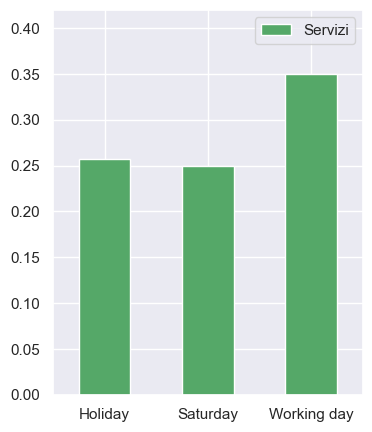

In [48]:
plt.figure(figsize=(4, 5))
W_daytype.Servizi.plot(kind='bar', color=colors[2])
plt.ylim((0,0.42))
plt.xlabel("")
plt.xticks(rotation=0)
plt.legend()

In [32]:
W_daytype = W[W['daytype'] == 'Working day'].groupby(['region', 'month'])[['Domestico', 'Industria', 'Servizi']].sum()
W_daytype = W_daytype.div(W_daytype.sum(axis=1), axis=0).round(2)
# W_daytype
W_daytype.unstack(level='region').T

month                     01    02    03    04    05    06    07    08    09  \
          region                                                               
Domestico Calabria      0.20  0.24  0.29  0.31  0.32  0.29  0.32  0.35  0.30   
          Centre.North  0.11  0.12  0.15  0.17  0.15  0.14  0.14  0.22  0.14   
          Centre.South  0.20  0.23  0.27  0.28  0.25  0.23  0.22  0.27  0.23   
          North         0.09  0.10  0.14  0.16  0.15  0.15  0.16  0.22  0.14   
          Sardinia      0.26  0.28  0.30  0.30  0.30  0.29  0.30  0.35  0.30   
          Sicily        0.32  0.34  0.35  0.35  0.32  0.31  0.34  0.36  0.32   
          South         0.26  0.27  0.32  0.32  0.29  0.28  0.29  0.30  0.29   
Industria Calabria      0.35  0.31  0.29  0.35  0.36  0.34  0.34  0.31  0.36   
          Centre.North  0.46  0.48  0.48  0.48  0.50  0.49  0.48  0.42  0.49   
          Centre.South  0.30  0.31  0.31  0.36  0.40  0.39  0.38  0.37  0.39   
          North         0.51  0.53  0.50  0.51  0.52  0.51  0.50  0.45  0.52   
          Sardinia      0.41  0.43  0.42  0.49  0.52  0.50  0.45  0.42  0.49   
          Sicily        0.22  0.25  0.28  0.35  0.42  0.40  0.38  0.38  0.38   
          South         0.32  0.32  0.33  0.39  0.42  0.42  0.43  0.41  0.42   
Servizi   Calabria      0.45  0.46  0.42  0.34  0.32  0.37  0.34  0.34  0.34   
          Centre.North  0.43  0.40  0.37  0.34  0.36  0.36  0.38  0.36  0.37   
          Centre.South  0.50  0.46  0.42  0.36  0.35  0.38  0.40  0.37  0.39   
          North         0.40  0.38  0.36  0.33  0.34  0.35  0.34  0.33  0.34   
          Sardinia      0.33  0.30  0.28  0.21  0.18  0.21  0.25  0.24  0.21   
          Sicily        0.46  0.41  0.37  0.30  0.26  0.29  0.28  0.27  0.30   
          South         0.42  0.40  0.35  0.29  0.29  0.30  0.29  0.29  0.29   

month                     10    11    12  
          region                          
Domestico Calabria      0.27  0.21  0.24  
          Centre.North  0.14  0.12  0.12  
          Centre.South  0.25  0.22  0.22  
          North         0.12  0.09  0.10  
          Sardinia      0.30  0.28  0.27  
          Sicily        0.32  0.32  0.32  
          South         0.31  0.28  0.26  
Industria Calabria      0.37  0.35  0.38  
          Centre.North  0.48  0.47  0.48  
          Centre.South  0.36  0.32  0.31  
          North         0.51  0.51  0.51  
          Sardinia      0.49  0.44  0.42  
          Sicily        0.36  0.27  0.25  
          South         0.36  0.31  0.31  
Servizi   Calabria      0.36  0.45  0.38  
          Centre.North  0.38  0.42  0.40  
          Centre.South  0.40  0.46  0.47  
          North         0.37  0.41  0.40  
          Sardinia      0.21  0.28  0.31  
          Sicily        0.32  0.41  0.44  
          South         0.33  0.40  0.43

## NMF separately per year and month

350 iterations for year 2021
2.0162842439017747e-05 error

760 iterations for year 2022
2.4820968359502122e-05 error

290 iterations for year 2018
2.1373044284315178e-05 error

350 iterations for year 2019
1.915438741659806e-05 error

320 iterations for year 2020
1.7827873310029324e-05 error

330 iterations for year 2021
2.174992789334239e-05 error

370 iterations for year 2022
2.2620604592634936e-05 error

300 iterations for year 2018
1.987664769024828e-05 error

300 iterations for year 2019
1.9571945128601385e-05 error

320 iterations for year 2020
1.7967610596407666e-05 error

860 iterations for year 2021
3.0627650993856766e-05 error

410 iterations for year 2022
2.4578809326844834e-05 error

440 iterations for year 2018
2.3021413899242847e-05 error

320 iterations for year 2019
1.8320435868580304e-05 error

360 iterations for year 2020
2.2635644459434907e-05 error

310 iterations for year 2021
2.7099439020256315e-05 error

1030 iterations for year 2022
2.4818273242671926e-05 error


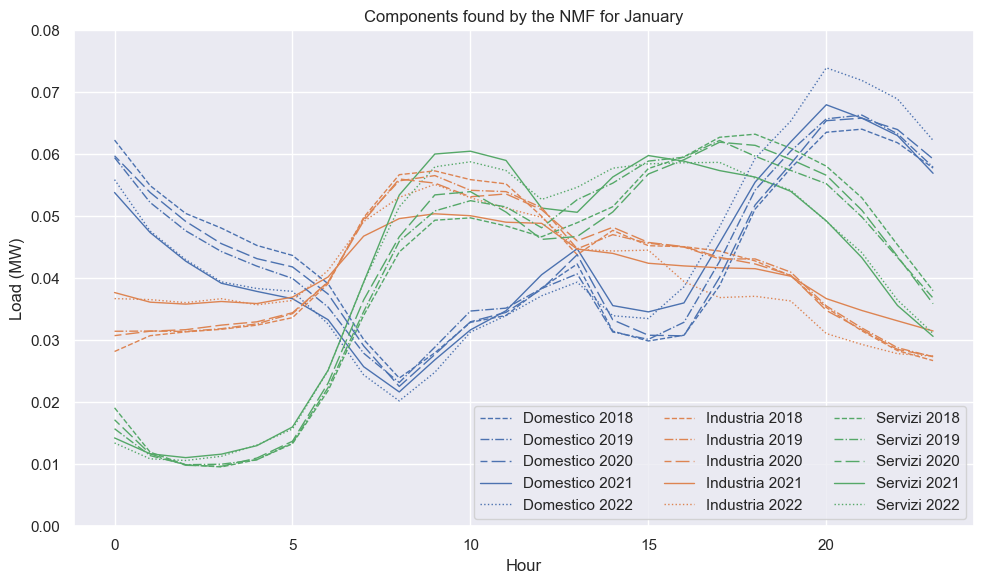

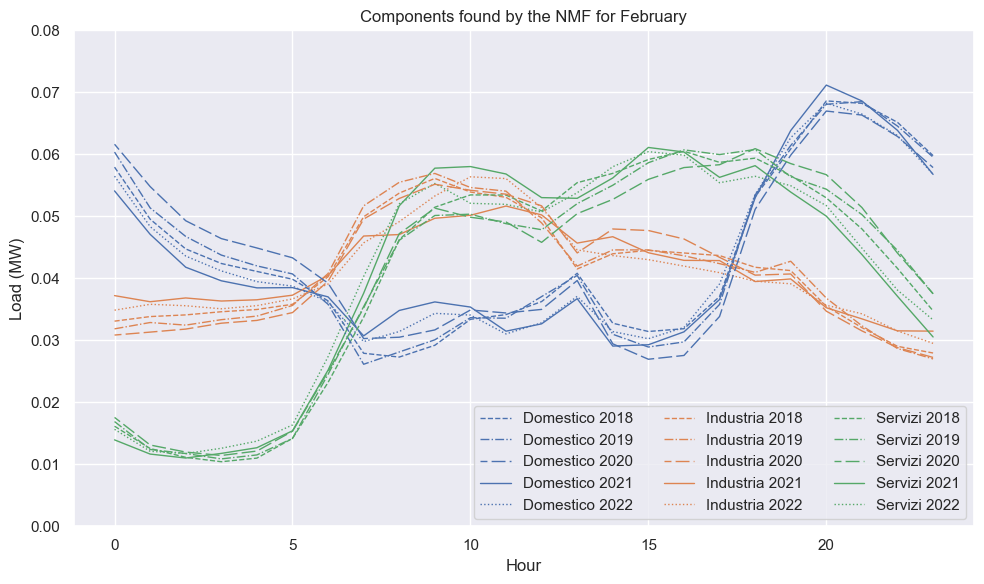

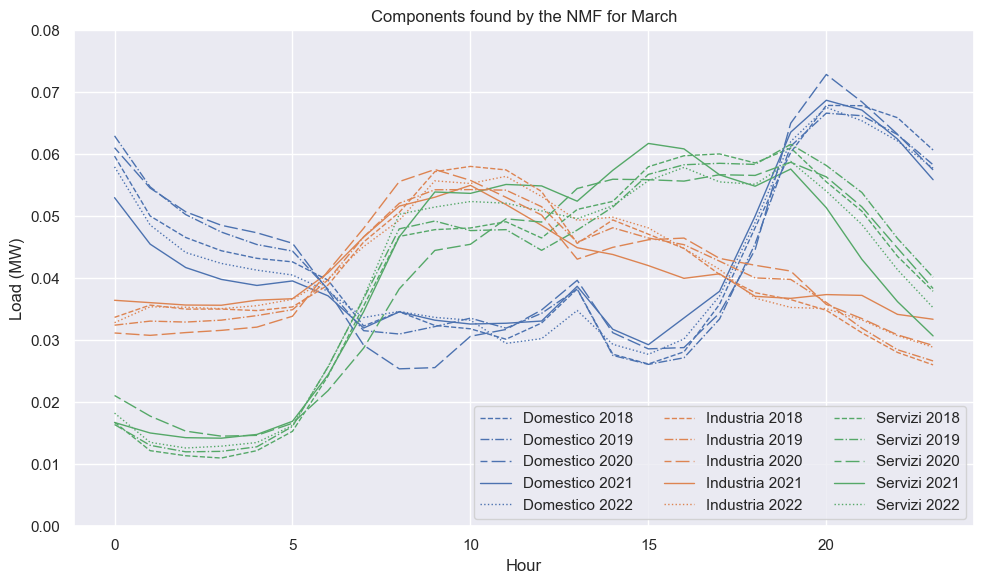

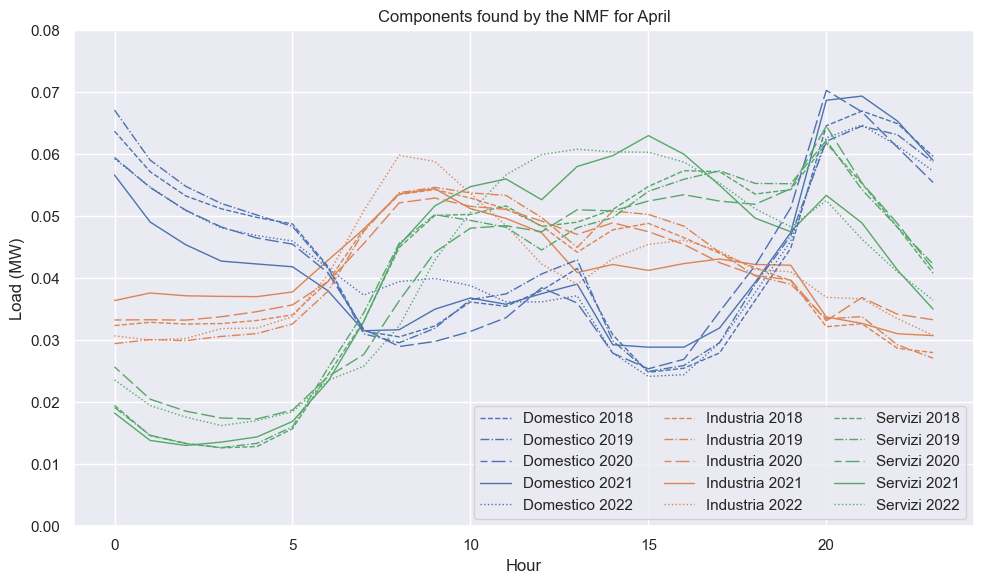

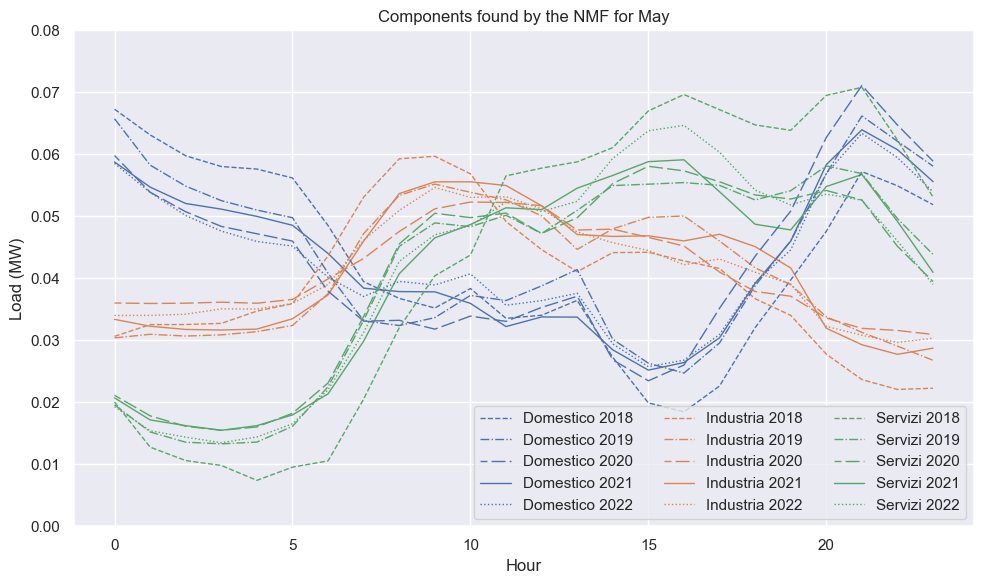

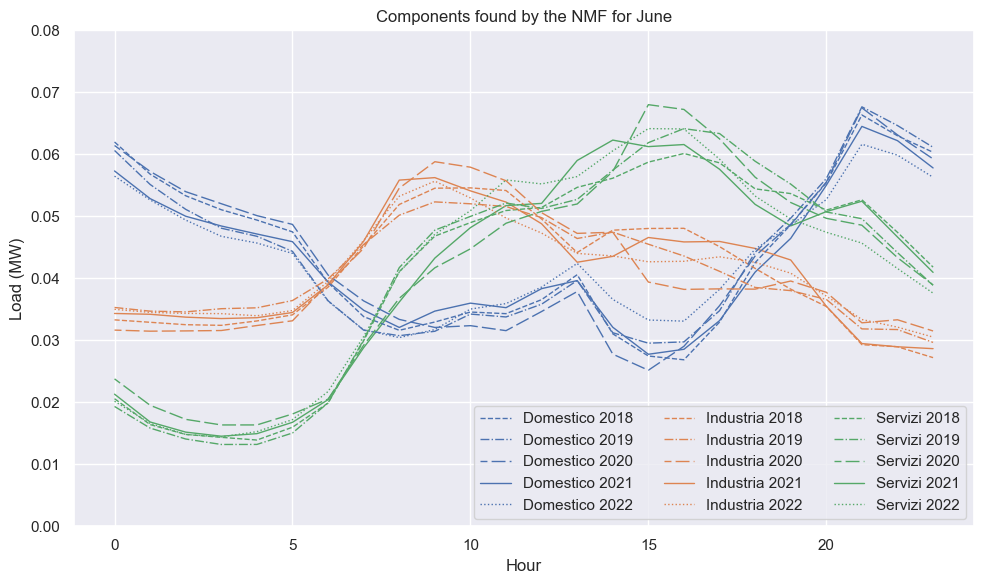

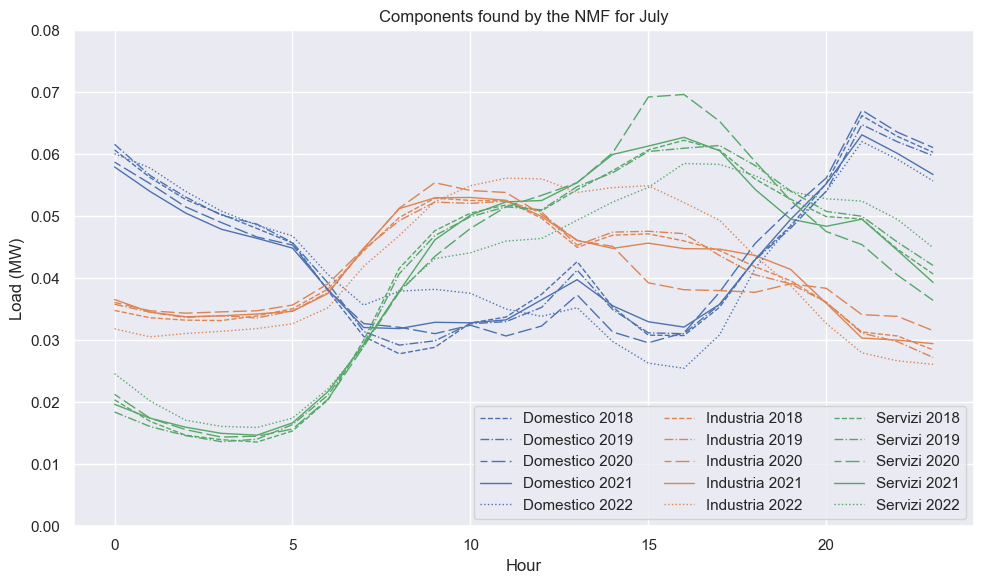

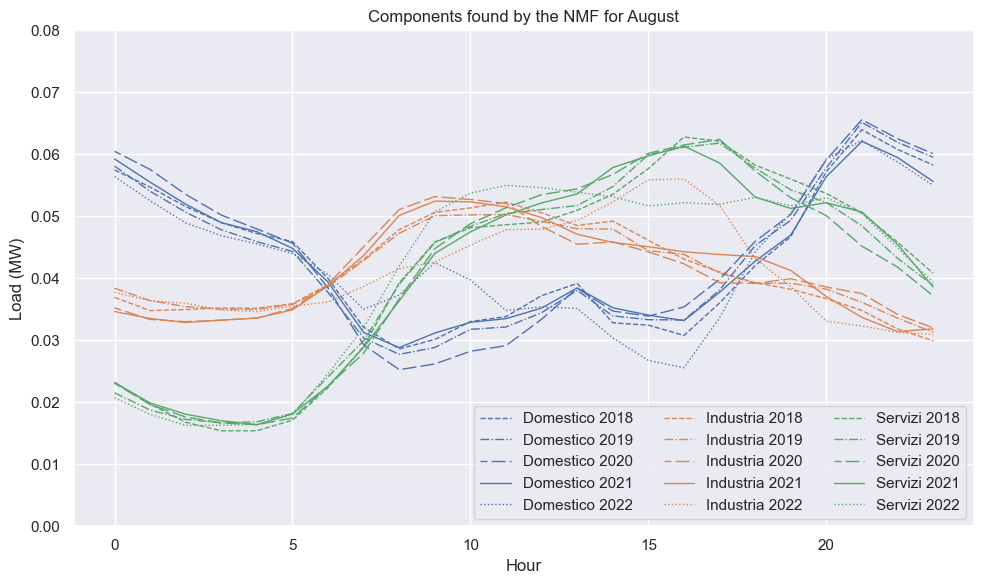

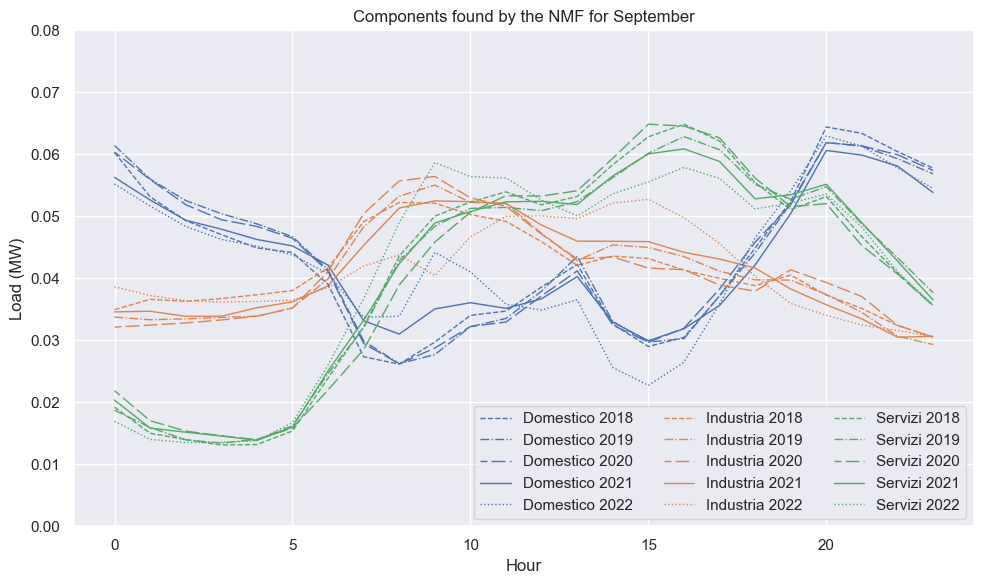

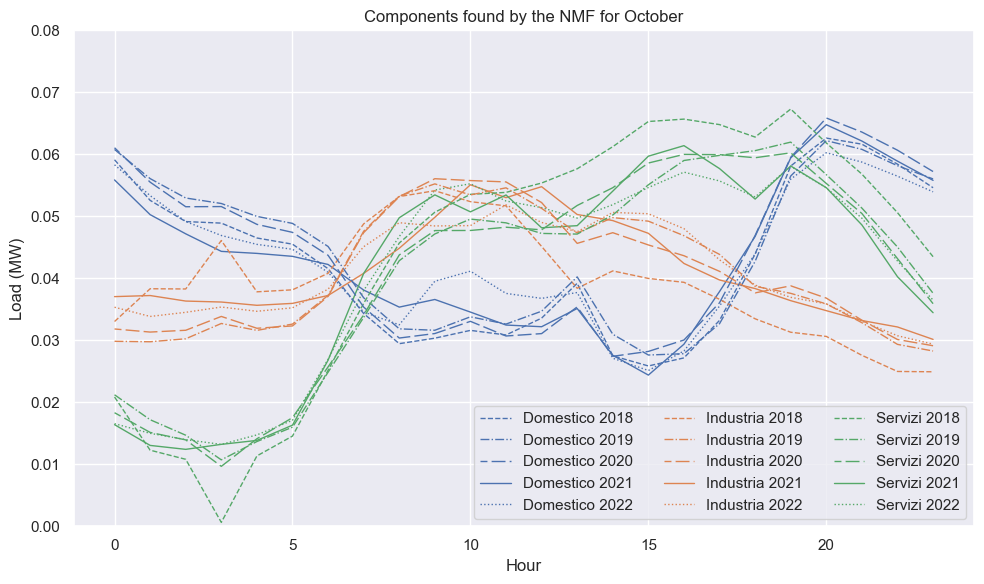

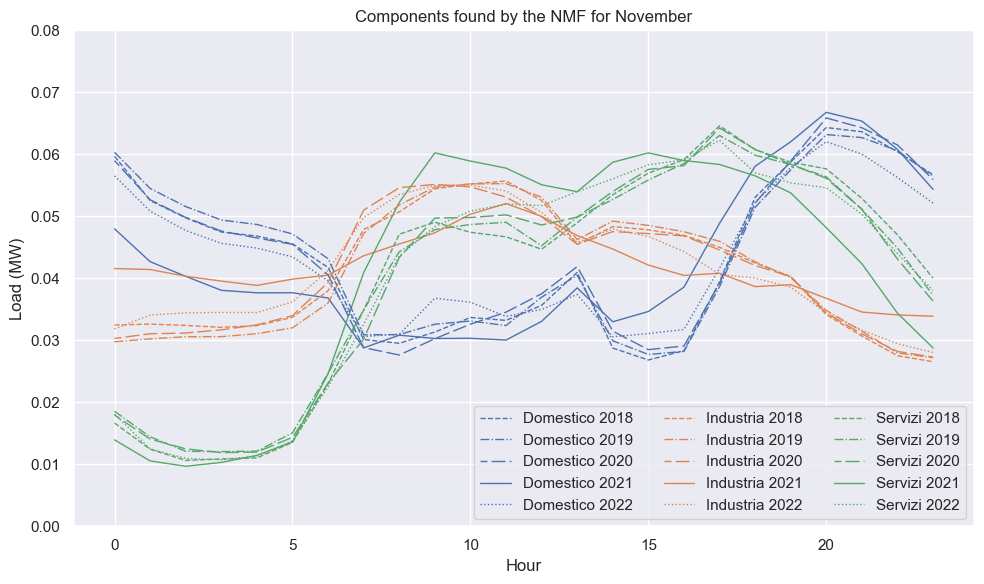

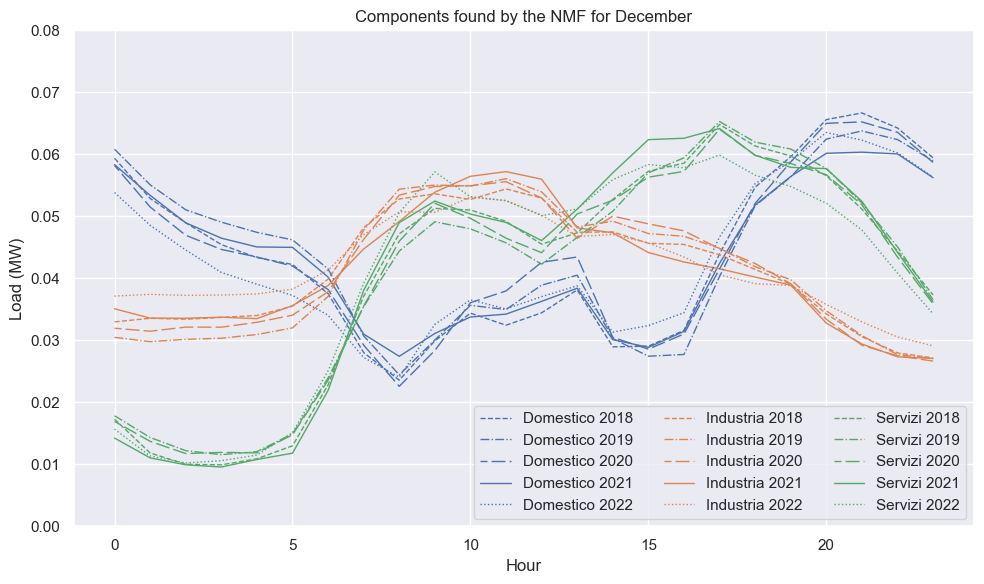

In [39]:
# month = '01'
for month in month_mapping.keys():
    
    df_month = df[df.month == month]
    X_month = X[df.month == month]

    linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (5, (10, 3))]
    fig, ax = plt.subplots(figsize=(10, 6))

    legend_entries = []  # To store legend entries for sorting

    for i, year in enumerate(df.year.unique()):

        X_month_year = X_month[df_month.year == year]
        df_month_year = df_month[df_month.year == year]

        W_init_month_year = df_month_year[['region']]
        W_init_month_year = W_init_month_year.merge(region_cons_df, how='left', left_on='region', right_index=True)
        W_init_month_year.drop('region', axis=1, inplace=True)
        W_init_month_year = W_init_month_year.mul(X_month_year.sum(axis=1), axis=0)

        W_init_month_year = initialize_W(df_month_year, X_month_year, region_cons_df)
        H_init = np.ones((n_components, 24)) / 24

        W_month_year = model.fit_transform(
            X_month_year.values,
            W=W_init_month_year.values.copy(order='C'),
            H=H_init
        )

        H_month_year = model.components_

        print('{} iterations for year {}'.format(model.n_iter_, year))
        print('{} error\n'.format(model.reconstruction_err_/X_month_year.size))

        for k, component in enumerate(W_init_month_year.columns):
            line, = ax.plot(H_month_year[k, :], linewidth=1, linestyle=linestyles[i], label=component + ' ' + year, color=colors[k])
            legend_entries.append((component + ' ' + year, line))

    # Sort the legend entries alphabetically
    legend_entries.sort(key=lambda entry: entry[0])

    # Unpack sorted legend entries for plotting
    labels, lines = zip(*legend_entries)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_ylim((0, .08))
    ax.set_title('Components found by the NMF for {}'.format(month_mapping.get(month)))
    ax.legend(lines, labels, ncol=3, loc='lower right')  # Use the sorted labels and lines for legend


    plt.tight_layout()
    plt.savefig('documents/plots/profiles/month_yearly/{}_{}_3_sectors_profiles.png'.format(month, month_mapping.get(month)))

## NMF separately per year

400 iterations for year 2021
7.914065981027886e-06 error

450 iterations for year 2022
7.812590557663602e-06 error

440 iterations for year 2018
7.239553984569659e-06 error

550 iterations for year 2019
7.067942512616397e-06 error

530 iterations for year 2020
7.077752951949611e-06 error



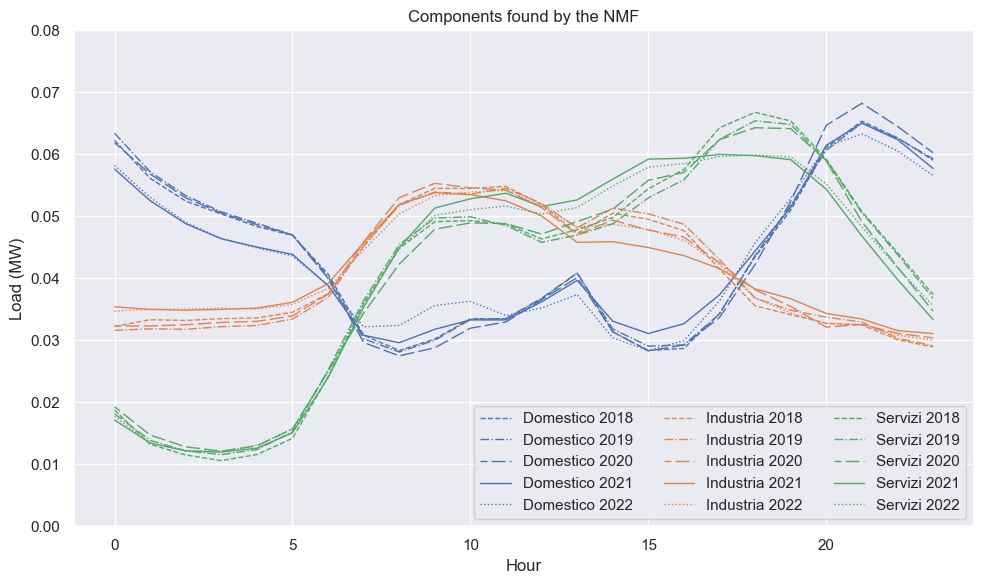

In [40]:
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (5, (10, 3)), (0, (5, 10))]
fig, ax = plt.subplots(figsize=(10, 6))

legend_entries = []  # To store legend entries for sorting

for i, year in enumerate(df.year.unique()):

    X_year = X[df.year == year]
    df_year = df[df.year == year]

    W_init_year = initialize_W(df_year, X_year, region_cons_df)
    H_init = np.ones((n_components, 24)) / 24

    W_month_year = model.fit_transform(
        X_year.values,
        W=W_init_year.values.copy(order='C'),
        H=H_init
    )

    H_year = model.components_

    print('{} iterations for year {}'.format(model.n_iter_, year))
    print('{} error\n'.format(model.reconstruction_err_/X_year.size))

    for k, component in enumerate(W_init_year.columns):
        line, = ax.plot(H_year[k, :], linewidth=1, linestyle=linestyles[i], label=component + ' ' + year, color=colors[k])
        legend_entries.append((component + ' ' + year, line))

# Sort the legend entries alphabetically
legend_entries.sort(key=lambda entry: entry[0])

# Unpack sorted legend entries for plotting
labels, lines = zip(*legend_entries)

ax.set_xlabel('Hour')
ax.set_ylabel('Load (MW)')
ax.set_ylim((0, .08))
ax.set_title('Components found by the NMF')
ax.legend(lines, labels, ncol=3, loc='lower right')  # Use the sorted labels and lines for legend


plt.tight_layout()
plt.savefig('documents/plots/profiles/yearly/all_years_3_sectors_profiles.png')

___

# Tests

In [114]:
# Decompose the load data per sector with the profiles found
k = 2

X = df.drop(unit_info.columns, axis=1)
norm_X = X.sum(axis=1)
W_k = W[:,k]
H_k = H[k,:]

load_k = pd.DataFrame((norm_X * W_k).values.reshape((len(X), 1)).dot(H_k.reshape((1, 24))), columns=range(24), index=X.index)
cons_k = load_k.sum(axis=1)
load_k = pd.concat([load_k, unit_info], axis=1)
cons_k = pd.concat([cons_k, unit_info], axis=1).rename({0: W_init.columns[k]}, axis=1)
load_k

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,region,year,month,daytype
Calabria_2021-01-02_Saturday,113.282431,86.364389,77.013677,74.315438,80.105519,97.475545,159.034583,232.464700,291.118209,324.257936,...,403.302170,397.358942,362.232308,310.313181,266.767950,224.317931,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,133.338314,101.654617,90.648424,87.472481,94.287656,114.732926,187.190574,273.620993,342.658707,381.665597,...,474.704074,467.708638,426.363073,365.252017,313.997400,264.031895,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,168.175187,128.213592,114.331847,110.326135,118.921889,144.708830,236.097254,345.109072,432.184047,481.382142,...,598.728484,589.905372,537.757584,460.680240,396.034493,333.014660,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,112.942478,86.105216,76.782564,74.092423,79.865128,97.183027,158.557331,231.767090,290.244584,323.284861,...,402.091889,396.166496,361.145274,309.381953,265.967399,223.644769,Calabria,2021,01,Working day
Calabria_2021-01-06_Holiday,126.617791,96.531017,86.079559,83.063689,89.535366,108.950153,177.755787,259.829938,325.388009,362.428873,...,450.778021,444.135169,404.873505,346.842571,298.171291,250.724149,Calabria,2021,01,Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
South_2022-12-27_Working day,501.285080,382.170294,340.792540,328.852586,354.474222,431.338168,703.742524,1028.677486,1288.224607,1434.870919,...,1784.648858,1758.349531,1602.910975,1373.164106,1180.472493,992.627291,South,2022,12,Working day
South_2022-12-28_Working day,775.664215,591.351773,527.325844,508.850539,548.496216,667.431757,1088.937042,1591.725638,1993.336263,2220.249651,...,2761.479067,2720.784764,2480.266683,2124.767523,1826.605869,1535.943316,South,2022,12,Working day
South_2022-12-29_Working day,318.250285,242.628017,216.358570,208.778265,225.044644,273.843169,446.784210,653.075298,817.853682,910.954857,...,1133.017978,1116.321354,1017.638256,871.779124,749.445220,630.188152,South,2022,12,Working day
South_2022-12-30_Working day,513.059130,391.146608,348.796984,336.576588,362.800018,441.469324,720.271840,1052.838788,1318.482083,1468.572784,...,1826.566214,1799.649175,1640.559720,1405.416618,1208.199115,1015.941855,South,2022,12,Working day


In [115]:
cons_k

,Servizi,region,year,month,daytype
Calabria_2021-01-02_Saturday,6275.478555,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,7386.509324,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,9316.358906,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,6256.646289,Calabria,2021,01,Working day
Calabria_2021-01-06_Holiday,7014.214198,Calabria,2021,01,Holiday
...,...,...,...,...,...
South_2022-12-27_Working day,27769.564542,South,2022,12,Working day
South_2022-12-28_Working day,42969.277025,South,2022,12,Working day
South_2022-12-29_Working day,17630.031651,South,2022,12,Working day
South_2022-12-30_Working day,28421.808658,South,2022,12,Working day


<Axes: xlabel='month'>

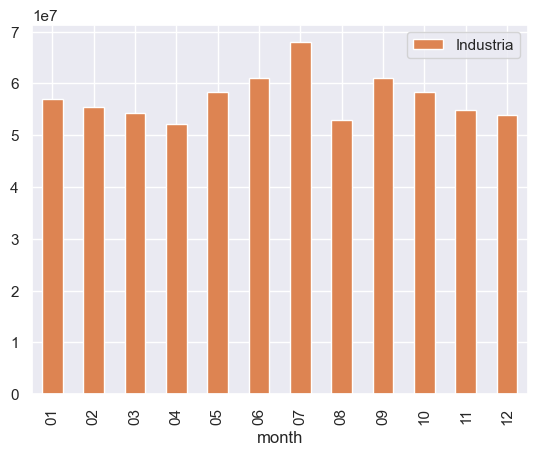

In [107]:
cons_k.groupby('month')[W_init.columns[k]].sum().plot(kind='bar', legend=True, color=colors[k])

<Axes: xlabel='month'>

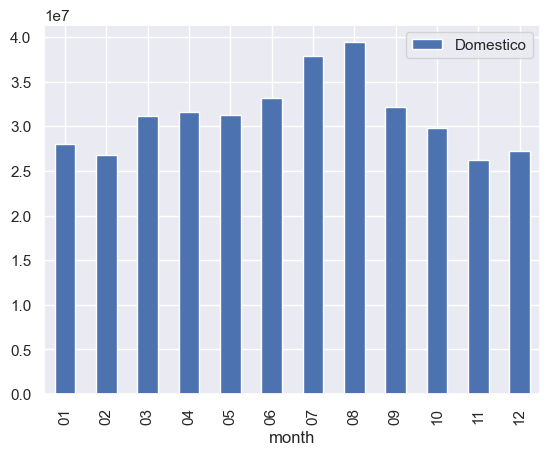

In [112]:
cons_k.groupby('month')[W_init.columns[k]].sum().plot(kind='bar', legend=True, color=colors[k])

<Axes: xlabel='month'>

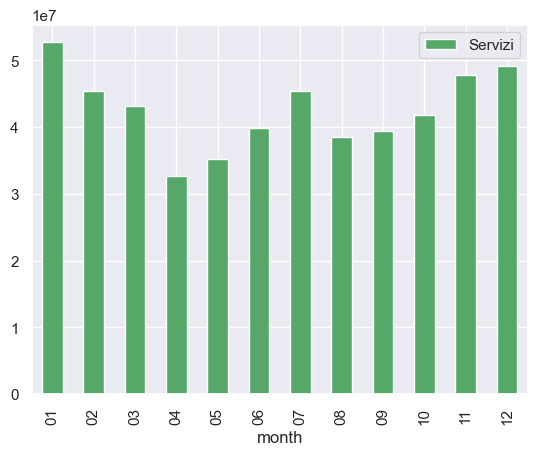

In [116]:
cons_k.groupby('month')[W_init.columns[k]].sum().plot(kind='bar', legend=True, color=colors[k])

<Axes: xlabel='month'>

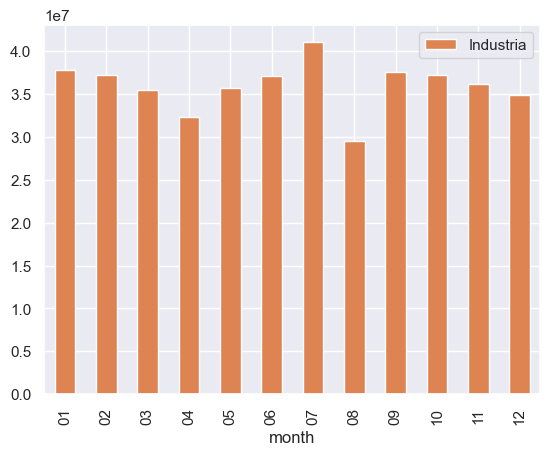

In [109]:
cons_k[cons_k.region=='North'].groupby('month')[W_init.columns[k]].sum().plot(kind='bar', legend=True, color=colors[k])

<Axes: xlabel='month'>

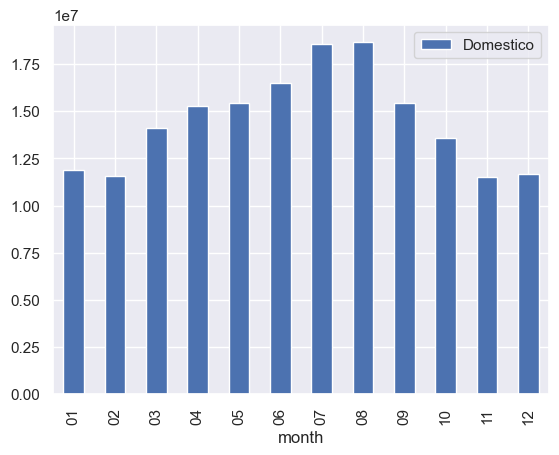

In [113]:
cons_k[cons_k.region=='North'].groupby('month')[W_init.columns[k]].sum().plot(kind='bar', legend=True, color=colors[k])

<Axes: xlabel='month'>

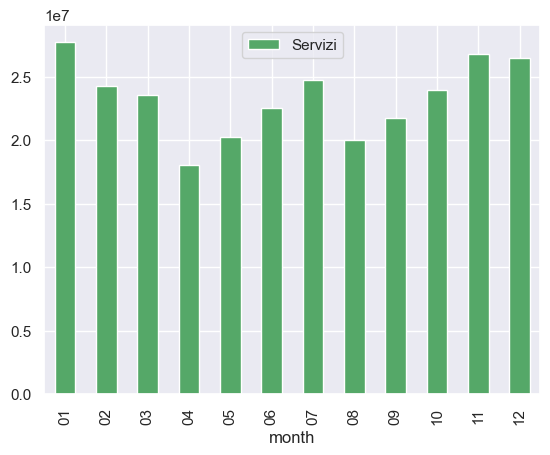

In [117]:
cons_k[cons_k.region=='North'].groupby('month')[W_init.columns[k]].sum().plot(kind='bar', legend=True, color=colors[k])